In [5]:
import os
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential,load_model,save_model
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D
from keras.layers import BatchNormalization
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#Data Generators
train_datagen = ImageDataGenerator(rescale = 1./255,
      rotation_range=25,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

In [20]:
batch_size = 64
target_size = (224, 224)
input_shape=(224, 224, 3)
seed=1337
adam = 0.001
fre= -20
FC = 2048
E = 1
patience = 3
verbose = 1
factor = 0.50
min_lr = 0.0001
steps_per_epoch=256
validation_steps=256
epochs=10

In [4]:
test_datagen = ImageDataGenerator( rescale = 1.0/255)

train_generator = train_datagen.flow_from_directory('/Users/sukanya/Desktop/Gender/Dataset/Training',
                                                    batch_size =batch_size ,
                                                    class_mode = 'binary',
                                                    seed=seed,
                                                    target_size = target_size )

validation_generator =  test_datagen.flow_from_directory( '/Users/sukanya/Desktop/Gender/Dataset/Validation',
                                                          batch_size  = batch_size,
                                                          class_mode  = 'binary',
                                                          seed=seed,
                                                          target_size = target_size)

Found 47009 images belonging to 2 classes.
Found 11649 images belonging to 2 classes.


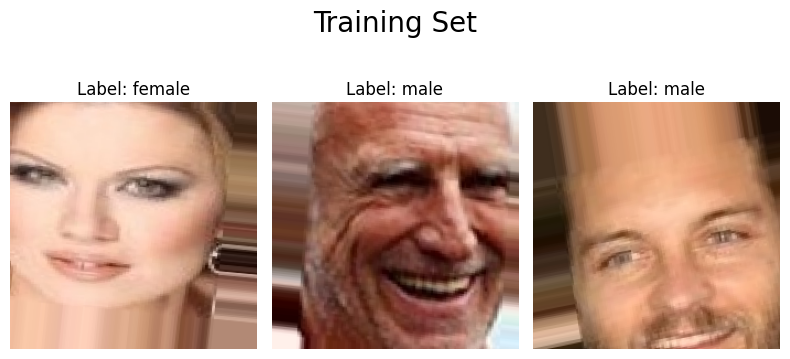

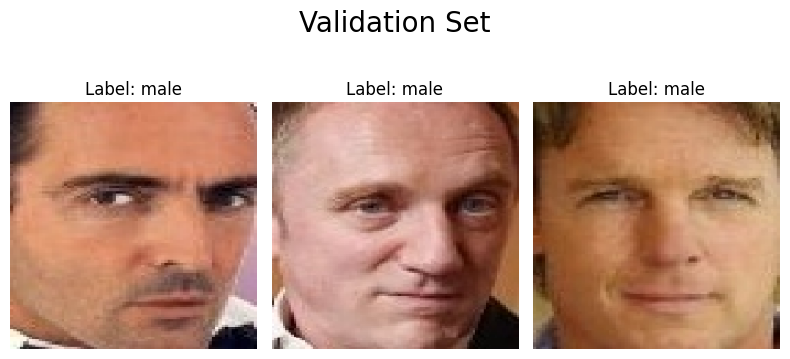

In [5]:
# Function to plot images
def plot_images(images_arr, labels, class_indices, title):
    fig, axes = plt.subplots(1, 3, figsize=(8, 8))
    axes = axes.flatten()

    # Maping numerical labels to class names
    inv_class_indices = {v: k for k, v in class_indices.items()}
    for img, ax, label in zip(images_arr, axes, labels):
        class_name = inv_class_indices[int(label)]
        ax.imshow(img)
        ax.set_title(f'Label: {class_name}')
        ax.axis('off')
    plt.tight_layout()
    plt.subplots_adjust(top=1.4)
    plt.suptitle(title, size=20)
    plt.show()

class_indices = train_generator.class_indices

train_images, train_labels = next(train_generator)
validation_images, validation_labels = next(validation_generator)

plot_images(train_images[:3], train_labels[:3], class_indices, 'Training Set')
plot_images(validation_images[:3], validation_labels[:3], class_indices, 'Validation Set')


In [6]:
base_model = tf.keras.applications.InceptionV3(input_shape=input_shape,include_top=False,weights="imagenet")

In [7]:
# Freezing Layers
for layer in base_model.layers[:fre]:
    layer.trainable=False

In [8]:
#Additional Layers

model=Sequential()
model.add(base_model)

model.add(Conv2D(512, (3, 3),strides=(1,1), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(layers.Dropout(.1))
model.add(Conv2D(128, (3, 3),strides=(1,1), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(layers.Dropout(.1))

model.add(Flatten())
model.add(layers.Dropout(.2))
model.add(Dense(FC, activation='relu'))
model.add(layers.Dropout(.2))
model.add(Dense(1, activation='sigmoid'))


In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 conv2d_94 (Conv2D)          (None, 5, 5, 512)         9437696   
                                                                 
 batch_normalization_94 (Ba  (None, 5, 5, 512)         2048      
 tchNormalization)                                               
                                                                 
 dropout (Dropout)           (None, 5, 5, 512)         0         
                                                                 
 conv2d_95 (Conv2D)          (None, 5, 5, 128)         589952    
                                                                 
 batch_normalization_95 (Ba  (None, 5, 5, 128)         512       
 tchNormalization)                                      

In [10]:
model.compile(optimizer=Adam(adam),
              loss='binary_crossentropy'
              ,metrics=['accuracy'])

In [11]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',
                        patience = patience,
                        verbose = verbose ,
                        factor = factor,
                        min_lr = min_lr)

mcp = ModelCheckpoint('model.h5')

es = EarlyStopping(verbose=verbose, patience=patience)

In [12]:
%time
history = model.fit_generator(generator=train_generator,
                           validation_data=validation_generator,
                           steps_per_epoch=steps_per_epoch,
                           validation_steps=validation_steps,
                           epochs=epochs,
                           callbacks=[lrd, mcp, es])

CPU times: user 0 ns, sys: 1 µs, total: 1 µs
Wall time: 1.91 µs


/var/folders/_x/1j3rm6sd6cn3kd7qpmy3s_k40000gn/T/ipykernel_2705/1721512554.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_generator,


Epoch 1/10
256/256 [==============================] - ETA: 0s - loss: 0.3852 - accuracy: 0.8744WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 256 batches). You may need to use the repeat() function when building your dataset.


256/256 [==============================] - 446s 2s/step - loss: 0.3852 - accuracy: 0.8744 - val_loss: 0.2692 - val_accuracy: 0.8807 - lr: 0.0010
Epoch 2/10


/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


256/256 [==============================] - ETA: 0s - loss: 0.2381 - accuracy: 0.9062WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,lr


256/256 [==============================] - 304s 1s/step - loss: 0.2381 - accuracy: 0.9062 - lr: 0.0010
Epoch 3/10
256/256 [==============================] - ETA: 0s - loss: 0.2239 - accuracy: 0.9122WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,lr


256/256 [==============================] - 288s 1s/step - loss: 0.2239 - accuracy: 0.9122 - lr: 0.0010
Epoch 4/10
256/256 [==============================] - ETA: 0s - loss: 0.2092 - accuracy: 0.9197WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,lr


256/256 [==============================] - 297s 1s/step - loss: 0.2092 - accuracy: 0.9197 - lr: 0.0010
Epoch 5/10
256/256 [==============================] - ETA: 0s - loss: 0.2129 - accuracy: 0.9186WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,lr


256/256 [==============================] - 290s 1s/step - loss: 0.2129 - accuracy: 0.9186 - lr: 0.0010
Epoch 6/10
256/256 [==============================] - ETA: 0s - loss: 0.2114 - accuracy: 0.9216WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,lr


256/256 [==============================] - 296s 1s/step - loss: 0.2114 - accuracy: 0.9216 - lr: 0.0010
Epoch 7/10
256/256 [==============================] - ETA: 0s - loss: 0.2074 - accuracy: 0.9230WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,lr


256/256 [==============================] - 308s 1s/step - loss: 0.2074 - accuracy: 0.9230 - lr: 0.0010
Epoch 8/10
256/256 [==============================] - ETA: 0s - loss: 0.1843 - accuracy: 0.9306WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,lr


256/256 [==============================] - 296s 1s/step - loss: 0.1843 - accuracy: 0.9306 - lr: 0.0010
Epoch 9/10
256/256 [==============================] - ETA: 0s - loss: 0.2003 - accuracy: 0.9271WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,lr


256/256 [==============================] - 301s 1s/step - loss: 0.2003 - accuracy: 0.9271 - lr: 0.0010
Epoch 10/10
256/256 [==============================] - ETA: 0s - loss: 0.1879 - accuracy: 0.9310WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,lr


256/256 [==============================] - 295s 1s/step - loss: 0.1879 - accuracy: 0.9310 - lr: 0.0010


In [14]:
model.save('Gender-Classfication Model.h5')

## Testing the model on random images

In [32]:
model = load_model('/Users/sukanya/Desktop/Gender/Gender-Classfication Model.h5')

1/1 [==============================] - 0s 34ms/step
Image: male1.jpg, Predicted value: 0.9807
Prediction: This is a male


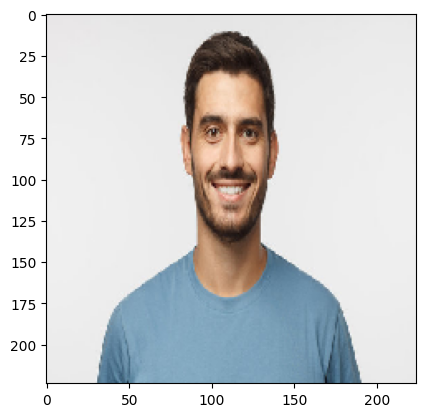

1/1 [==============================] - 0s 39ms/step
Image: man2.jpg, Predicted value: 0.9540
Prediction: This is a male


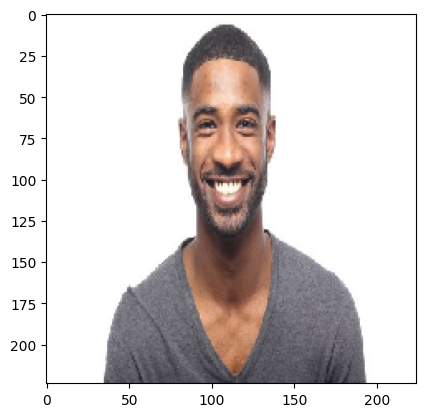

1/1 [==============================] - 0s 39ms/step
Image: female1.jpg, Predicted value: 0.4827
Prediction: This is a female


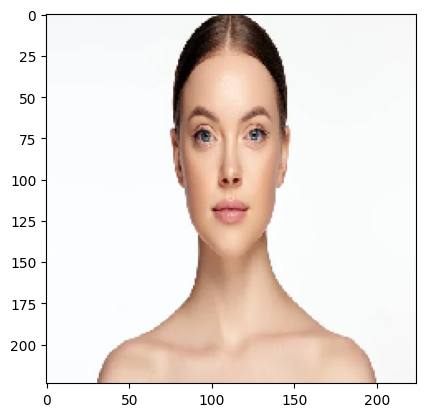

In [42]:
target_size = 224 
folder_path = '/Users/sukanya/Desktop/Gender/Test-Images'

for filename in os.listdir(folder_path):
    if filename.endswith(".jpg") or filename.endswith(".png"):  # Assuming images are JPEG or PNG
        # preprocessing
        img_path = os.path.join(folder_path, filename)
        img = image.load_img(img_path, target_size=(target_size, target_size))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = x / 255.0 

        # Predictions
        predictions = model.predict(x)
        predicted_value = predictions[0, 0]
        
        print(f"Image: {filename}, Predicted value: {predicted_value:.4f}")

        threshold = 0.5  
        if predicted_value > threshold:
            print("Prediction: This is a male")
        else:
            print("Prediction: This is a female")

        plt.imshow(img)
        plt.show()